# Instructions

1. This exam is worth 20% of the final grade.
2. In the questions below, insert a cell (code or markdown, as appropriate), and fill in your answers there.
2. It is a take-home EXAMINATION to assess your understanding of the material, and extend the ideas by learning on your own. 
2. You are required to work on it individually. Any form of plagiarism will result in 0.
2. Good, efficient Python code will get more marks than code that is not neat, difficult to understand and least importantly, slow.
3. Please submit your notebook file (name it `IND5003_THE_<Your_Name>.ipynb`) through Canvas before **15th Oct 2023 23:59hrs**.

# Data

The files `MRCI_clus_2310.csv` and `MRCI_regr_2310.csv` contain information on institutional characteristics, enrollment, costs, and student outcomes for 856 and 851 four-year colleges, respectively, in the United States of America. The column headings are
* `ADM_RATE`: admission rate
* `SAT_AVG`: average SAT equivalent score of students admitted
* `UGDS`: enrollment of undergraduate degree-seeking students
* `COSTT4_A`: average cost of attendance
* `C150_4`: completion rate for first-time, full-time students (150% of expected time to completion)
* `UGDS_WOMEN`: total share of enrollment of undergraduate degree-seeking students who are women
* `STUFACR`: undergraduate student to instructional faculty ratio
* `MD_EARN_WNE_1YR`: median earnings of graduates working and not enrolled 1 year after completing
* `STATE`: Alabama, Alaska, ..., Wisconsin (the files do not contain colleges in Wyoming)

# Contents
* [Question 1](#Question-1:-Clustering)
    * [Q1 Step 1](#Step-1:)
    * [Cophenetic Correlation Coefficient](#Cophenetic-Correlation-Coefficient:)
    * [Q1 Step 2](#Step-2:)
    * [Q1 Step 2.2](#Step-2.2:)
    * [Q1 Step 2.3](#Step-2.3:)
    * Q1 Step 3
    * Q1 Step 3.1

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

# Question 1: Clustering

**Use the data in the file `MRCI_clus_2310.csv`.**

Cluster the colleges on the five variables `ADM_RATE`, `SAT_AVG`, `C150_4`, `UGDS_WOMEN`, and `STUFACR` **after standardisation** using an **appropriately chosen** linkage method for **each of**
1. Euclidean distance
2. Manhattan distance

*You can choose an appropriate linkage method using what is known as the cophenetic correlation coefficient, but include a small paragraph or two on what is the cophenetic correlation coefficient and how you used it to choose your linkage mathod.*

In **each** case, use the silhouette scores to find the optimal or near-optimal number of clusters, and outline the properties/differences of the clusters you identified.

----
Inffering from linkage methods mentioned in the question, it is inherintently implied that hierarchical clustering methods should used.  
This means that methods like DBSCAN can not be used. (Unless it is HDBSCAN, which will not explored in this take home assignment.)  

When applied in a bottom up manner, this is known as agglomerative clustering.  
When applied in an up down manner, this is known as divisive clustering.  
Both methods will produce a dendrogram.  

My thought process in steps:  
1. Apply standard scaler on the 5 features.  
2. Try the different linkage methods for Euclidean distance.   
2.2. Find the silhouette score of the N clusters and identify optimal number of clusters to have using the best linkage method.  
2.3. Outline the properties/differences of the clusters I identified.
3. Try the different linkage methods for Manhattan distance.   
3.2. Find the silhouette score of the N clusters and identify optimal number of clusters to have using the best linkage method.  
3.3. Outline the properties/differences of the clusters I identified.

In [2]:
# Import the data and examine it
clus_df = pd.read_csv("./data/MRCI_clus_2310.csv")
display(clus_df.head())
clus_df.info()
clus_df.describe()

,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
0,0.7160,954.0,0.2807,0.5940,18.0
1,0.8854,1266.0,0.6245,0.6210,19.0
2,0.7367,1300.0,0.6072,0.4047,19.0
3,0.9799,955.0,0.2843,0.6495,13.0
4,0.7890,1244.0,0.7223,0.5615,19.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ADM_RATE    856 non-null    float64
 1   SAT_AVG     856 non-null    float64
 2   C150_4      856 non-null    float64
 3   UGDS_WOMEN  856 non-null    float64
 4   STUFACR     856 non-null    float64
dtypes: float64(5)
memory usage: 33.6 KB


,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
count,856.000000,856.000000,856.000000,856.000000,856.000000
mean,0.736254,1163.453271,0.600595,0.575898,13.759346
std,0.202226,128.004176,0.162513,0.115135,3.737971
min,0.039500,840.000000,0.157600,0.000000,5.000000
25%,0.646900,1075.750000,0.482050,0.516100,11.000000
50%,0.781300,1139.000000,0.600050,0.576650,13.000000
75%,0.881525,1232.000000,0.708600,0.631125,16.000000
max,1.000000,1535.000000,0.975700,1.000000,30.000000


From `.info()` method we can see that the dataset does not contain a null value.  
This means we do not have to use imputer for the values.  
We can also observe that some features have a very large value of thousands, like `SAT_AVG`, while others have very small values like `UGDS_WOMEN`.  
This means we need to standardise the data as instructed in the question.  

## Step 1: 
Apply standard scaler on the 5 features.

In [3]:
ss = StandardScaler()
clus_ss = ss.fit_transform(clus_df)
clus_ss_df = pd.DataFrame(clus_ss, columns=["adm_rate", "sat_avg", "c150_4", "ugds_women", "stufacr"])
clus_ss_df.head()

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
0,-0.100214,-1.637257,-1.969576,0.157315,1.135143
1,0.737952,0.801589,0.147183,0.391960,1.402825
2,0.002207,1.067360,0.040668,-1.487806,1.402825
3,1.205524,-1.629440,-1.947411,0.639641,-0.203263
4,0.260980,0.629619,0.749333,-0.125128,1.402825


The data have been standardised with `StandardScaler()` where the means are now 0, and standard deviations are now 1.  
It is important to note that due to application of `StandardScaler()`, the features have lost their explainability, as their values are changed and only the distribution remains.  

## Cophenetic Correlation Coefficient:  
* The cophenetic correlation coefficient (CPCC) is a measure used to assess the quality of hierarchical clustering methods, particularly agglomerative hierarchical clustering.  
* In hierarchical clustering, data points are successively merged into clusters to create a hierarchical tree-like structure called a dendrogram.   
* The cophenetic correlation coefficient measures how well the dendrogram preserves the pairwise distances between data points.  
* It is calculated by correlating the cophenetic distances (distances between the observations in the dendrogram) with the original pairwise distances between data points.   
* A higher cophenetic correlation coefficient indicates that the dendrogram preserves the original distances better, suggesting a more meaningful clustering.  
* The range of the cophenetic correlation coefficient is between -1 and 1, where values closer to 1 indicate a better clustering solution.  
* Therefore, the higher the resultant cophenetic correlation coefficient, the more favourable the linkage method. 

The exact steps of calculating the CPCC is as follows:   
1. Find the pairwise condensed distance matrix   
2. Find the condensed cophenetic distance matrix  
   2.1 Compute hierarchical clustering encoded as a linkage matrix  
   2.2 Use linkage matrix to find cophenetic distance matrix  
3. Find the correlation coefficient matrix of this 2 matrix   
4. The pearson correlation coefficientin the corr coeff matrix is the CPCC    

Math equation:  

$ {\displaystyle c={\frac {\sum _ {i<j} (x (i,j)-{\bar {x}}) (t (i,j)-{\bar {t}})}{\sqrt {\sum _ {i<j} (x (i,j)-{\bar {x}})^ {2}\sum _ {i<j} (t (i,j)-{\bar {t}})^ {2}}}}}$


Mannually transalting the steps into codes:
```
# Calculate pairwise distances
cond_dist_mat = pdist(clus_ss)

# Perform hierarchical clustering
link_mat = linkage(cond_dist_mat, method)
    
# Calculate cophenetic distance
cop_dist_mat = cophenet(link_mat)

# Calculate CPCC
cpcc = np.corrcoef(cop_dist, cond_dist_mat)[0][1])
```

Most important thing to remember:   
The closer the value is to 1, the better the clustering preserves the original distances.

## Step 2: 
Try the different linkage methods for Euclidean distance, and select the best linkage method.  

In this setp, we should start from the scratch/ basic.  
Links to documentations are included in the notebook.  

This means we need to take the following steps to find the :  
1. Find the pair-wise distance using [scipy.spatial.distance.pdist()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) method.   
2. Find the [CPCC](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html) for each linkage method using scipy method.  
3. Select the linkage method with the highest CPCC.  

The typical linkage methods are:
* Single Linkage
* Complete Linkage
* Centroid Linkage
* Ward's Linkage
* Average Linkage

In [4]:
# Calculate pairwise distances
cond_dist_mat = pdist(clus_ss, metric='euclidean')

In [5]:
# List of linkage methods to compare, as stated on scipy documentation page
linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

In [6]:
# Define a function to find the linkage method with the highest Cophenetic Correlation Coefficient
def find_cpcc(cond_dist_mat, linkage_methods):
    """Find the linkage method with the highest Cophenetic Correlation Coefficient
    Args:
        cond_dist_mat: array, condensed distance matrix
        linkage_methods: list, str of linkage methods
    Returns:
        best_dict: dict, {best_linkage: best_cpcc}
        cpcc_dict:, dict, {method: cpcc} for all methods listed in linkage methods
    """    
    # Calculate CPCC for each linkage method
    cpcc_scores = []
    cpcc_dict = {}
    print("The CPCC score for each method:")
    for method in linkage_methods:
        # Perform hierarchical clustering
        link_mat = linkage(cond_dist_mat, method=method)

        # Calculate CPCC directly
        cpcc, cop_dist_mat = cophenet(link_mat, cond_dist_mat)
        print(f"{method}: {cpcc:.3f}")
        cpcc_dict[method] = cpcc
        cpcc_scores.append(cpcc)

    # Plot CPCC scores for different linkage methods
    plt.figure(figsize=(8, 4))
    # plt.bar(linkage_methods, cpcc_scores)
    plt.bar(linkage_methods, cpcc_scores)
    plt.xlabel('Linkage Method')
    plt.ylabel('Cophenetic Correlation Coefficient (CPCC)')
    plt.title('CPCC for Different Linkage Methods')
    plt.ylim(0, 1)
    plt.show()

    # Select the best linkage method (highest CPCC)
    best_linkage = linkage_methods[np.argmax(cpcc_scores)]
    print(f"The best linkage method is '{best_linkage}' with a CPCC of {max(cpcc_scores):.3f}.")
    return {best_linkage:max(cpcc_scores)}, cpcc_dict

The CPCC score for each method:
single: 0.581
complete: 0.538
average: 0.767
weighted: 0.468
centroid: 0.760
median: 0.629
ward: 0.572


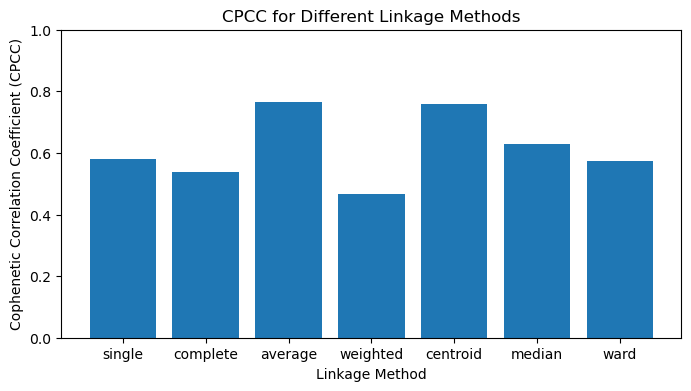

The best linkage method is 'average' with a CPCC of 0.767.


In [7]:
find_cpcc(cond_dist_mat, linkage_methods);

From step 2, we select `average` linkage method for the case of Euclidean distance.  
Now we move on to experiment with the different number of clusters.  
Average-linkage is where the distance between each pair of observations in each cluster are added up and divided by the number of pairs to get an average inter-cluster distance.   
Equation:
\begin{equation*} D_{xy} = \frac{1}{|N_x||N_y|} \sum_{i \in N_x} \sum_{j \in N_y} d(x_{i},y_{j}) \end{equation*}

## Step 2.2:  
Find the [silhouette scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) of the N clusters and identify optimal number of clusters to have using the best linkage method.  
The simplest way is to find how the silhouette score changes with number of cluster, and select the number of cluster with the best silhouette score.  
----
The special thing about hierarchical clustering is that there's no predetermined number of groups to cluster.  
So we should choose the number of clusters that makes the most sense to us.  
----

In [8]:
# Define the chosen linkage method
chosen_linkage = 'average'

In [9]:
def find_best_sil_score(data, cond_dist_mat, chosen_linkage, n):
    """Find the silhouette scores of the N clusters, ranging from 2 to N.
    Args:
        data: array, standard scaled data to cluster
        cond_dist_mat: array, condensed distance matrix
        chosen_linkage: str, name of linkage chosen
        n: number of clusters to form for the selected linkage method
    Returns:
        best_score_dict: dict, {best_cluster_num: best score}
        cluster_score_dict: dict, {cluster_num: score}
    """
    # Define a range of cluster numbers to consider
    cluster_range = range(2, n+1)
    # Lists to store silhouette scores
    silhouette_scores = []
    cluster_score_dict = {}
    # Perform hierarchical clustering
    link_mat = linkage(cond_dist_mat, method=chosen_linkage)    
    # Calculate silhouette scores for different numbers of clusters
    for n_clusters in cluster_range:
        cluster_labels = fcluster(link_mat, t=n_clusters, criterion='maxclust')
        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        cluster_score_dict[n_clusters] = silhouette_avg
        
    # Plot silhouette scores according to dendrogram level
    plt.figure(figsize=(16, 4))
    # plt.plot(dendrogram_dict['icoord'], silhouette_scores, marker='o', linestyle='-', markersize=6)
    plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs. Number of clusters for {chosen_linkage} Linkage')
    plt.grid(True)
    plt.show()

    # Select the number of clusters that maximizes the silhouette score
    optimal_num_clusters = cluster_range[np.argmax(silhouette_scores)]
    print(f"The optimal number of clusters for {chosen_linkage} linkage is {optimal_num_clusters}, with a silhouette score of {max(silhouette_scores):.3f}.")
    return {optimal_num_clusters:max(silhouette_scores)}, cluster_score_dict

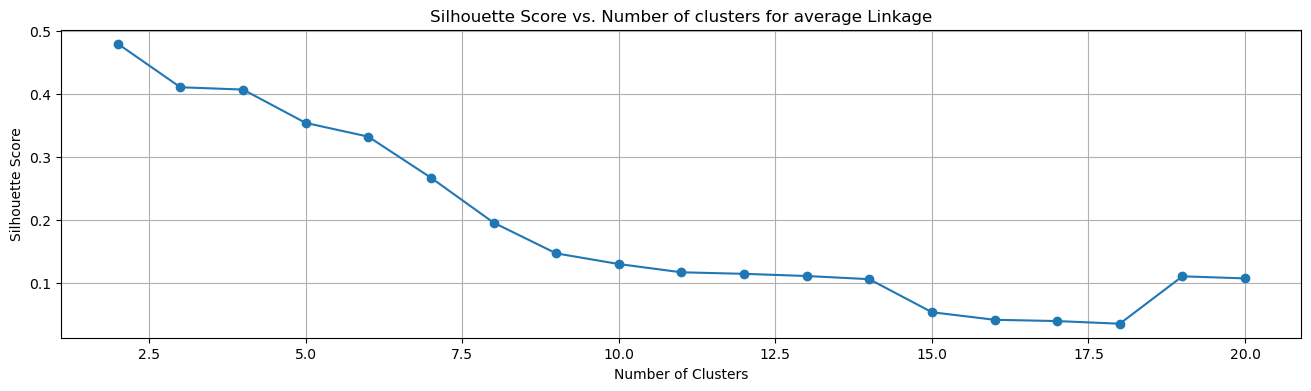

The optimal number of clusters for average linkage is 2, with a silhouette score of 0.479.


In [10]:
# Let n be 20. This means we examine up to 20 clusters
find_best_sil_score(clus_ss, cond_dist_mat, chosen_linkage, 20);

The Silhouette Score shows a constantly decreasing trend which is worrying.  
This is because according to the Silhouette Score, 2 cluster might be the best choice.  
However, know that hierarchical clustering tends to be very affected by outliers, and that they don't care about the balance in cluster size.  
The 2 clusters can end up with 1 data point in a cluster, and the rest of those 855 data points in another cluster...  
This is something we can't prevent, but we may not want to see.  
This means we need to use more aids to confirm our choice.  
----

One way to do so is to visualise how the clusters are split using a dendrogram.  
I will create a dendrogram below and observe how the clsuters are being split.  
If the last few clusters have long distance before they join, then that means they are split into distinct groups.  
Else, it means there are many outliers which didn't belong to any distinct groups.  

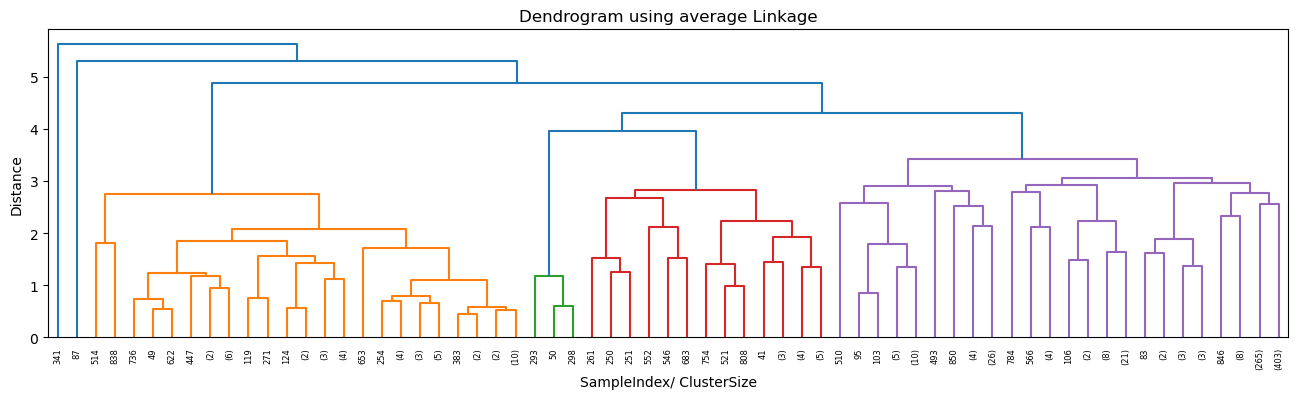

In [11]:
# Craete a dendrogram to visualise how the clusters are formed

# Perform hierarchical clustering
link_mat = linkage(cond_dist_mat, method=chosen_linkage)

# Create a dendrogram
plt.figure(figsize=(16, 4))
dendrogram_dict = dendrogram(link_mat, p=8, labels=range(1, len(clus_ss)+1), truncate_mode='level', count_sort=True)
plt.xlabel('SampleIndex/ ClusterSize')
plt.ylabel('Distance')
plt.title(f'Dendrogram using {chosen_linkage} Linkage');

Very unfortunately, we encountered the case where outliers are not part of any clusters.  
This is evident from sample index 341 and 87.  
These 2 trouble makers are a class of their own...  
So we can not simply conclude using silhoutte score only.  
We have to dig deeper into the data.  
One way to do so is use clustermap to examine how these points are like.  
----

Examine the resultant calssification in a visually intuitive way, using cluster heatmap.  
The dendrogram is on the left hand side.  
The index are on the right handside, while the feature names are at the bottom.  

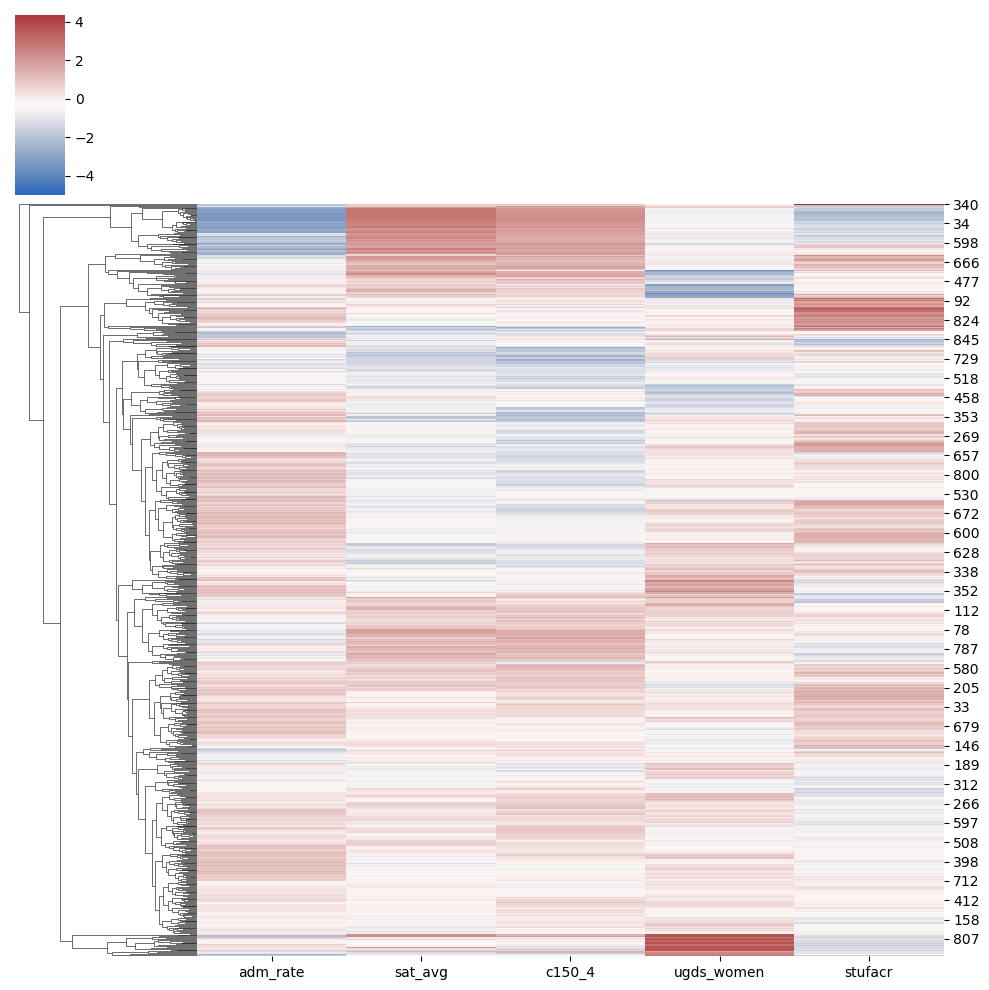

In [12]:
# Plot Clustermap of the MRCI_clus_2310 data
sns.clustermap(clus_ss_df, method=chosen_linkage, metric='euclidean', cmap="vlag", col_cluster=False);

From the cluster map, we can observe that it is actually really difficult to tell the different clusters apart.
This is very unfortunate for us, as we do not have a distinctive split if we just use hierarchical clustering alone.  
We can rule out some of the really bad options using the cluster map though.  
Looking at the clsutermap, I can say that about 2 to 6 clusters will be a good choice.  
This means we have to further our prob into the problem.  
This time, I will use a trick called the elbow method.  
----

Elbow method will helpme find the point of diminishing return to continue clustering the data.  
According to [wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), the goal is to minimize the total intra-cluster variation (WSS).   
Therefore, we can implement the Elbow Method as a reference for determining the optimal number of clusters:

In [13]:
# Define a function to implement the elbow method.  
def find_wss(K, data, metric, linkage):
    """Calculate the total intr-cluster variation (WSS)
    Args:
        K: int, examine up to K number of clusters
        data: array, the standardised data to cluster
        metric: str, 'euclidean' or 'mahattan (city block)'
        linkage: str, linkage type
    Returns:
        wss_lst: list, intr-cluster variation for different n clusters
    """
    # Have a place holder to hold the wss results
    wss_lst = []
    # Loop through K number of clusters
    for i in range(K):
        # Create the cluster transformer object
        cluster = AgglomerativeClustering(n_clusters= i+1, metric=metric, linkage=linkage)  
        # Apply the cluster object
        cluster.fit_predict(data)
        # Obtain the cluster label
        label = cluster.labels_
        wss = []
        # For each cluster
        for j in range(i+1):
            # extract each cluster according to its index
            idx = [t for t, e in enumerate(label) if e == j]
            cluster = data[idx,]
            # calculate the WSS:
            cluster_mean = cluster.mean(axis=0)
            distance = np.sum(np.abs(cluster - cluster_mean)**2,axis=-1)
            wss.append(sum(distance))
        wss_lst.append(sum(wss))
    return wss_lst

Apply the defined function and plot a graph explained variation agianst number of clusters. 

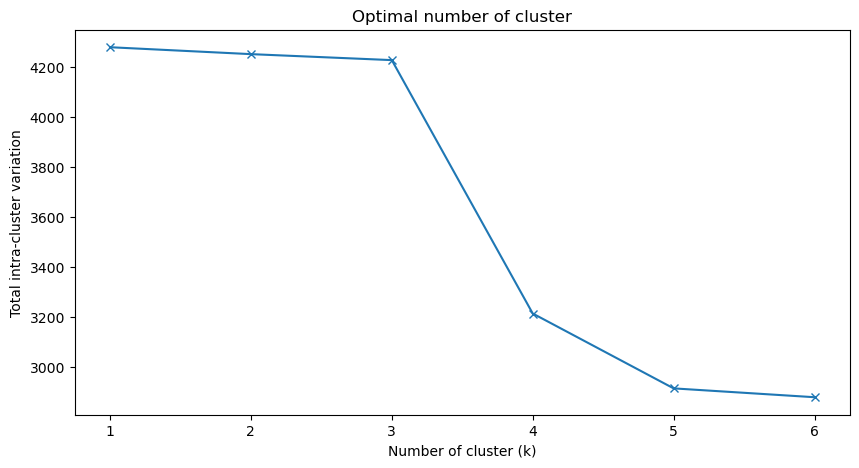

In [14]:
# Find the total intra-cluster variation for up to 6 clsuters
# 6 clusters is decided by looking at dendrogram and clutermap
wss_lst=find_wss(6, clus_ss, 'euclidean', chosen_linkage)
# Create the label
cluster_range = range(1, 7)
# Plot the result
plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster');
plt.xlabel('Number of cluster (k)');
plt.ylabel('Total intra-cluster variation');
plt.plot(cluster_range, wss_lst, marker = "x");

The gain in explained variance reduces significantly from 4 to 5 to 6 (‘elbow’ is at k = 5).   
So, optimal number of clusters could be 5.  
We have finally concluded that the near optimal number of clusters to have is 5.
----
Now we can plot a final fancy dendrogram to show the clustering process, just for fun.  =D  

In [15]:
# This code is purely for visualisation purpose and does not play a part in analysis
def fancy_dendrogram(*args, **kwargs):
    plt.figure(figsize=(10,5))
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata
# the following code is from
# [https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/]

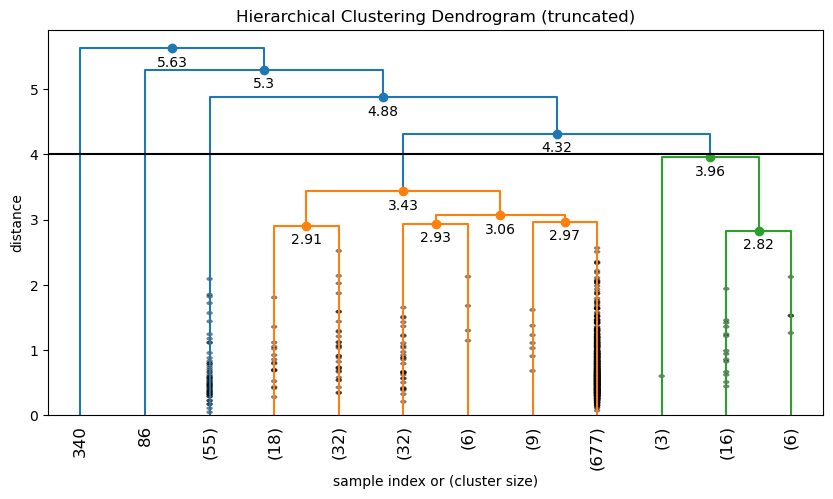

In [16]:
# Use the fancy dendrogram function
fancy_dendrogram(
    link_mat,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=4,  # a horizontal cut-off line
)

plt.show()

This is a much neater truncated dendrogram that indicates the distance at the point of merging into 1 cluster.   
By cutting at distance = 4, I am able to get a total of 5 clusters.  

## Step 2.3:
Now that we have finally determined the optimal numbe of clusters to have is 5, we should create the corresponding label and use them to examine the data in each cluster.  
To do so, we first label the data and decided which cluster they belongs to.   
I will use sklearn library to do so.  
Steps to take now:
* Create the label using sklearn
* Split the dataset
* Examine the different clusters
* Outline the properties/differences of the clusters I identified.

In [19]:
# Set the number of cluster to have to be 5
num_cluster = 5

In [20]:
# Create cluster object
cluster=AgglomerativeClustering(n_clusters=num_cluster, metric='euclidean', linkage=chosen_linkage)
# Fit the standard scaled data into the cluster object and predict the label
cluster.fit_predict(clus_ss)
# Find the label or result of the clustering
pred_label = cluster.labels_
# Reshape into the correct shape of (856,1), instead of default (856,)
pred_label = pred_label.reshape(-1,1)
# Stack the array and data together
# Append the label to the standard scaled data
clus_ss_w_label = np.hstack((clus_ss, pred_label))
# Change the matrix into dataframe for simpler analysis
clus_eucli_res_df = pd.DataFrame(clus_ss_w_label, columns=["adm_rate", "sat_avg", "c150_4", "ugds_women", "stufacr", "label"])

In [21]:
# Display the frist 5 rows to take a look at it.
clus_eucli_res_df.head()

,adm_rate,sat_avg,c150_4,ugds_women,stufacr,label
0,-0.100214,-1.637257,-1.969576,0.157315,1.135143,1.0
1,0.737952,0.801589,0.147183,0.391960,1.402825,1.0
2,0.002207,1.067360,0.040668,-1.487806,1.402825,1.0
3,1.205524,-1.629440,-1.947411,0.639641,-0.203263,1.0
4,0.260980,0.629619,0.749333,-0.125128,1.402825,1.0


In [ ]:
# Split into different groups and analyse 
# Pair plot
# Corr coeff


In [49]:
# Create cluster object
cluster=AgglomerativeClustering(n_clusters=num_cluster, metric='euclidean', linkage=chosen_linkage)
# Fit the standard scaled data into the cluster object and predict the label
cluster.fit_predict(clus_ss)
# Find the label or result of the clustering
pred_label = cluster.labels_
print(pred_label.shape)
# Append the label to the standard scaled data
clus_ss_w_label = np.vstack((clus_ss, pred_label))
# Change the matrix into dataframe for simpler analysis
clus_eucli_res_df = pd.DataFrame(clus_ss_w_label, columns=["adm_rate", "sat_avg", "c150_4", "ugds_women", "stufacr", "label"])

(856,)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 5 and the array at index 1 has size 856

np.unique(cluster_labels)

In [30]:
np.unique(cluster_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int32)

In [29]:
cluster_labels.unique

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [13]:
clus_ss

array([[-0.10021365, -1.63725691, -1.96957562,  0.15731517,  1.13514348],
       [ 0.73795242,  0.80158854,  0.14718345,  0.39195998,  1.40282469],
       [ 0.00220688,  1.06736016,  0.04066823, -1.48780565,  1.40282469],
       ...,
       [ 0.13530409, -0.51163594, -1.21781215, -0.06342476,  0.33209983],
       [ 1.30497622, -0.07389445, -1.9117003 , -1.334852  ,  1.13514348],
       [ 0.9220125 ,  0.75468766,  0.75241154, -0.98549195,  0.33209983]])

[[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
 [0.64589411 0.43758721 0.891773   0.96366276 0.38344152]
 [0.79172504 0.52889492 0.56804456 0.92559664 0.07103606]
 [0.0871293  0.0202184  0.83261985 0.77815675 0.87001215]
 [0.97861834 0.79915856 0.46147936 0.78052918 0.11827443]
 [0.63992102 0.14335329 0.94466892 0.52184832 0.41466194]
 [0.26455561 0.77423369 0.45615033 0.56843395 0.0187898 ]
 [0.6176355  0.61209572 0.616934   0.94374808 0.6818203 ]
 [0.3595079  0.43703195 0.6976312  0.06022547 0.66676672]
 [0.67063787 0.21038256 0.1289263  0.31542835 0.36371077]]


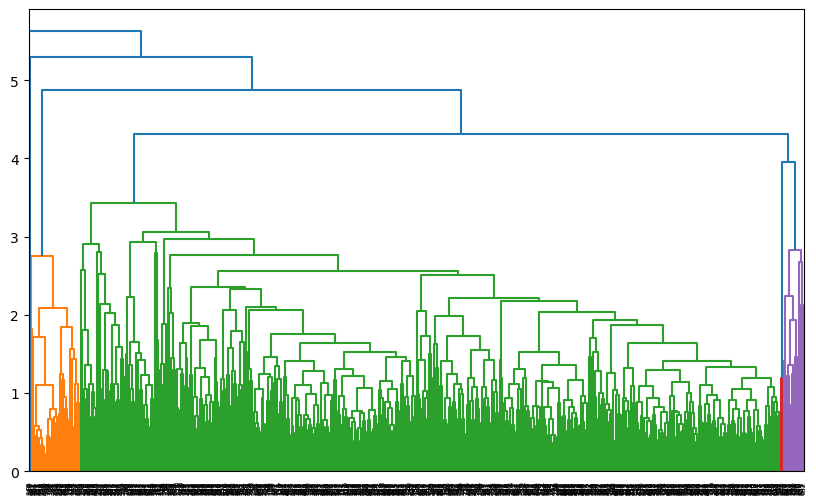

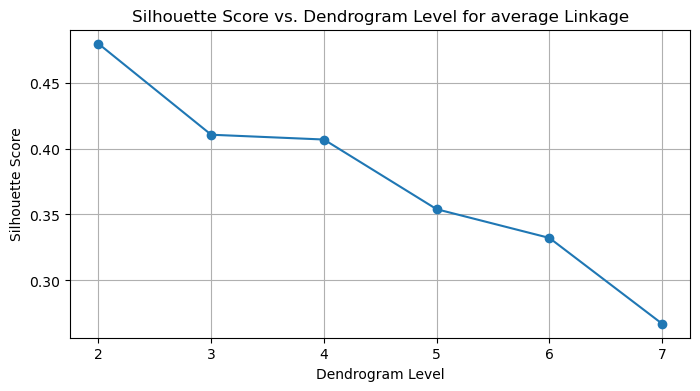

The optimal number of clusters for average linkage is 2


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet
from sklearn.metrics import silhouette_score

# Generate some sample data with 5 features (replace this with your own data)
np.random.seed(0)
X = np.random.rand(10, 5)
print(X)

# Calculate pairwise distances
distances = pdist(clus_ss)

# Define the chosen linkage method
chosen_linkage = 'average'

# Perform hierarchical clustering
linkage = hierarchy.linkage(distances, method=chosen_linkage)

# Create a dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(linkage)

# Define a range of cluster numbers to consider
cluster_range = range(2, 8)

# Lists to store silhouette scores
silhouette_scores = []

# Calculate silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    cluster_labels = hierarchy.fcluster(linkage, t=n_clusters, criterion='maxclust')
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(clus_ss, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores according to dendrogram level
plt.figure(figsize=(8, 4))
# plt.plot(dendrogram['icoord'], silhouette_scores, marker='o', linestyle='-', markersize=6)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Dendrogram Level')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score vs. Dendrogram Level for {chosen_linkage} Linkage')
plt.grid(True)
plt.show()

# Select the number of clusters that maximizes the silhouette score
optimal_num_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters for {chosen_linkage} linkage is {optimal_num_clusters}")


In [12]:
# Try the different linkage methods for Euclidean distance.
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward', metric='euclidean')

In [13]:
model = model.fit(clus_ss_df)

In [18]:
link_arr = linkage(clus_ss, method="single", metric="euclidean", optimal_ordering=True)

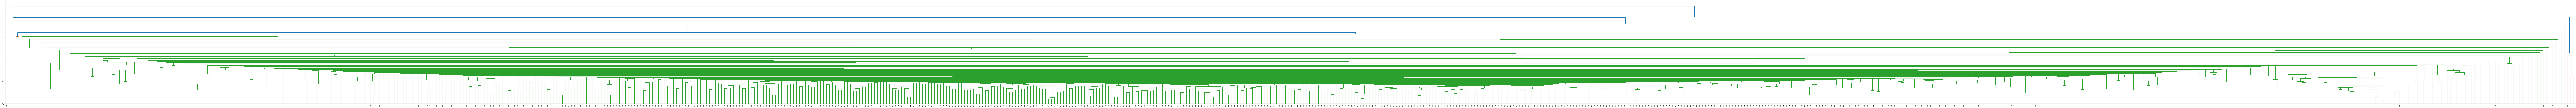

In [20]:
fig = plt.figure(figsize=(250,10))
dn = dendrogram(link_arr)
plt.show()

In [4]:
c, coph_dists = cophenet(link_arr, distances)

NameError: name 'link' is not defined

c, coph_dists = cophenet(link, distances)

In [7]:
clus_df.describe()

,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
count,856.000000,856.000000,856.000000,856.000000,856.000000
mean,0.736254,1163.453271,0.600595,0.575898,13.759346
std,0.202226,128.004176,0.162513,0.115135,3.737971
min,0.039500,840.000000,0.157600,0.000000,5.000000
25%,0.646900,1075.750000,0.482050,0.516100,11.000000
50%,0.781300,1139.000000,0.600050,0.576650,13.000000
75%,0.881525,1232.000000,0.708600,0.631125,16.000000
max,1.000000,1535.000000,0.975700,1.000000,30.000000


<Axes: xlabel='ADM_RATE'>

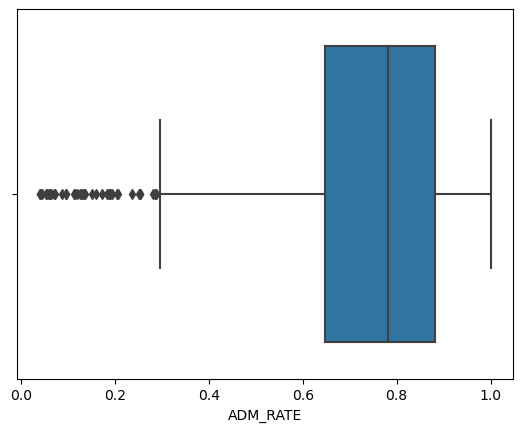

In [9]:
sns.boxplot(x=clus_df["ADM_RATE"])

<Axes: xlabel='SAT_AVG'>

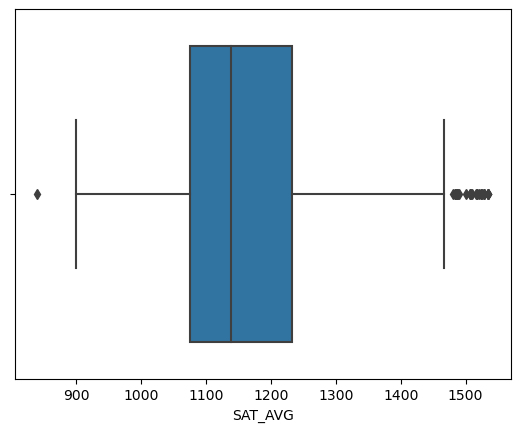

In [10]:
sns.boxplot(x=clus_df["SAT_AVG"])

<Axes: xlabel='C150_4'>

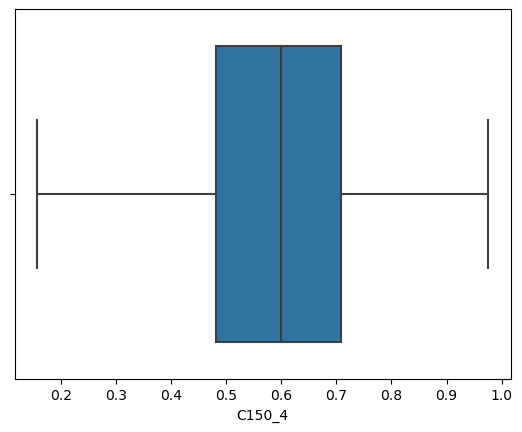

In [11]:
sns.boxplot(x=clus_df["C150_4"])

<Axes: xlabel='SAT_AVG', ylabel='ADM_RATE'>

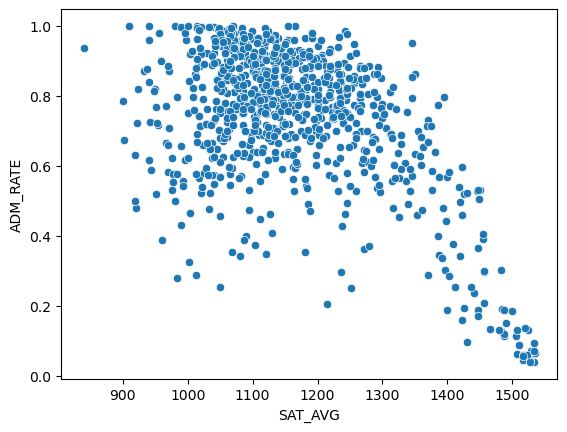

In [6]:
sns.scatterplot(data=clus_df, x="SAT_AVG", y="ADM_RATE")

# Question 2: Regression

**Use the data in the file `MRCI_regr_2310.csv`.**

Use the `statsmodels` package. After you fit a regression model in **each** part, be sure to
* assess its fit,
* study the residuals,
* check for influential points, and
* check for multicollinearity.

*For multicollinearity, you can report what is known as the Variance Inflation Factor (VIF) of the model, but include a small paragraph or two on what is multicollinearity and how it can affect your model.*

1. Fit a regression model of `MD_EARN_WNE_1YR` on all of `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `C150_4`, `UGDS_WOMEN` and `STUFACR`. *Do not standardise these variables.* Outline your findings and suggest *a few* other regression models you might consider fitting. *There is no need at this point to fit the regression models you suggested.*

Here are a couple of comments from your boss when you show him/her the analysis:
* "Have you tried standardising the variables `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `C150_4`, `UGDS_WOMEN` and `STUFACR`?"
* "Have you tried adding `STATE` to your explanatory variables?"

2. Address his/her questions and other concerns you may have from part 1. You may remove the *most influential* point if it exists. Recommend a final regression model.

part 1 take it at face value. fit everything except state.
observe what works and what doesn't work
say what you might do for the issues highlighted
part 2 improve on part 1 and consider the 2 additional variables.
dummy var and one hot encoding for states. one hot encode to remove exact linear dependence
